In [1]:
import torch
from torch.optim.lr_scheduler import StepLR
from torch.nn import MSELoss
from src.spaces.hyperbolic import HyperbolicSpace
from src.spectral_kernel import RandomSpectralKernel, RandomFourierFeatureKernel
from src.prior_approximation import RandomFourierApproximation
from src.spectral_measure import MaternSpectralMeasure, SqExpSpectralMeasure
import matplotlib.pyplot as plt
import gpytorch
import os
import sys
sys.setrecursionlimit(2000)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
torch.autograd.set_detect_anomaly(True)
dtype = torch.float32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel

    def forward(self, x):  # pylint: disable=arguments-differ
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [3]:
def train(model, train_x, train_y):
    training_iter = 900
    # Find optimal model hyperparameters
    model.train()
    model.likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters
    scheduler = StepLR(optimizer, step_size=300, gamma=0.1)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        #print(scheduler.get_lr())
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step()
        if i % 100 == 99:
            try:
                lengthscale = model.covar_module.base_kernel.lengthscale.item()
                variance = model.covar_module.outputscale
            except:
                lengthscale = model.covar_module.kernel.measure.lengthscale.item()
                variance = model.covar_module.kernel.measure.variance.item()
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f variance: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                lengthscale,
                variance,
                model.likelihood.noise.item()
            ))

In [4]:
order = 10**3
space = HyperbolicSpace(n=2, order=order)

In [5]:
def plot_disc(x, y):
    fig, ax = plt.subplots()
    plt.scatter(x.detach().cpu()[:, 0], x.detach().cpu()[:, 1], c=y.detach().cpu())
    circle = plt.Circle((0, 0), 1, facecolor="none", edgecolor="black")
    ax.add_patch(circle)
    plt.show()

In [6]:
def f(x):
    x_norm = x/torch.norm(x, dim=1, keepdim=True)
    angle_ = torch.arccos(x_norm[:, 0])
    return torch.sin(2*space._dist_to_id(x)+2*angle_)
    #return 1/(1 + torch.square(space._dist_to_id(x)))


lspace = torch.linspace(-1, 1, 50, device=device, dtype=dtype)
test_x = torch.cartesian_prod(lspace, lspace)
test_x = test_x[torch.norm(test_x, dim=1) < 0.99]

train_x = space.rand(200)
train_y, test_y = f(train_x), f(test_x)
print("test variance: ", torch.var(test_y))

test variance:  tensor(0.5054, device='cuda:0')


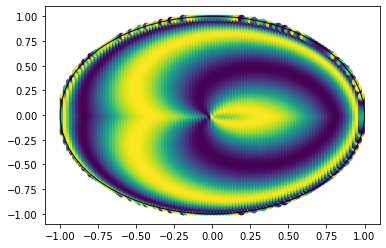

In [7]:
lspace = torch.linspace(-1, 1, 100, device='cpu', dtype=dtype)
x = torch.cartesian_prod(lspace, lspace)
x = x[torch.norm(x, dim=1) < 1]
plot_disc(x, f(x))

In [8]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
euclidean_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
euclidean_model = ExactGPModel(train_x, train_y, likelihood, euclidean_kernel).to(device=device)
train(euclidean_model, train_x, train_y)

C:\Users\Iskander\anaconda3\envs\geomkernel\lib\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Iter 100/900 - Loss: 1.063   lengthscale: 1.074 variance: 0.347   noise: 0.459
Iter 200/900 - Loss: 1.059   lengthscale: 0.995 variance: 0.183   noise: 0.464
Iter 300/900 - Loss: 1.054   lengthscale: 0.647 variance: 0.091   noise: 0.460
Iter 400/900 - Loss: 1.052   lengthscale: 0.569 variance: 0.085   noise: 0.458
Iter 500/900 - Loss: 1.045   lengthscale: 0.469 variance: 0.081   noise: 0.450
Iter 600/900 - Loss: 1.017   lengthscale: 0.371 variance: 0.093   noise: 0.423
Iter 700/900 - Loss: 1.012   lengthscale: 0.364 variance: 0.095   noise: 0.419
Iter 800/900 - Loss: 1.008   lengthscale: 0.359 variance: 0.096   noise: 0.414
Iter 900/900 - Loss: 1.005   lengthscale: 0.354 variance: 0.098   noise: 0.410


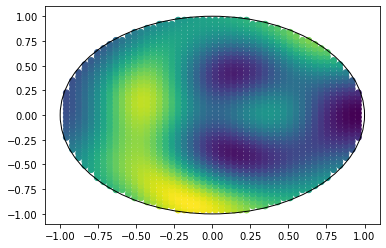

euclidean error: tensor(0.3977)


In [9]:
euclidean_model.eval()
with torch.no_grad(), gpytorch.settings.skip_posterior_variances(state=True):
    euclidean_f = euclidean_model(test_x)
euclidean_pred_y = euclidean_f.mean
plot_disc(test_x, euclidean_pred_y)
error = MSELoss()(euclidean_pred_y, test_y)
print("euclidean error:", error.detach().cpu())

In [10]:
lengthscale, nu, variance = 0.1, 5.0 + space.dim, 3.0
measure = SqExpSpectralMeasure(space.dim, lengthscale, variance=variance)
#self.measure = MaternSpectralMeasure(self.space.dim, self.lengthscale, self.nu)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
geometric_spectral_kernel = RandomSpectralKernel(measure, space)
geometric_rff_kernel = RandomFourierFeatureKernel(geometric_spectral_kernel)
geometric_model = ExactGPModel(train_x, train_y, likelihood, geometric_rff_kernel).to(device=device)
train(geometric_model, train_x, train_y)

Iter 100/900 - Loss: 0.845   lengthscale: 0.799 variance: 2.123   noise: 0.270
Iter 200/900 - Loss: 0.577   lengthscale: 0.806 variance: 1.331   noise: 0.103
Iter 300/900 - Loss: 0.388   lengthscale: 0.630 variance: 0.475   noise: 0.048
Iter 400/900 - Loss: 0.400   lengthscale: 0.629 variance: 0.477   noise: 0.046
Iter 500/900 - Loss: 0.391   lengthscale: 0.630 variance: 0.474   noise: 0.043
Iter 600/900 - Loss: 0.362   lengthscale: 0.620 variance: 0.476   noise: 0.041
Iter 700/900 - Loss: 0.335   lengthscale: 0.620 variance: 0.475   noise: 0.040
Iter 800/900 - Loss: 0.342   lengthscale: 0.620 variance: 0.474   noise: 0.040
Iter 900/900 - Loss: 0.362   lengthscale: 0.620 variance: 0.473   noise: 0.040


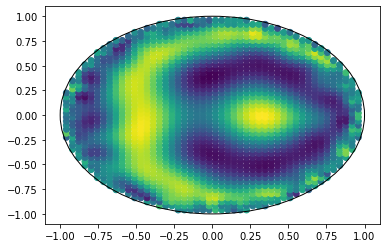

geometric heat kernel error: tensor(0.1042)


In [11]:
geometric_model.eval()
with torch.no_grad(), gpytorch.settings.skip_posterior_variances(state=True):
    euclidean_f = geometric_model(test_x)
geometric_f = geometric_model(test_x)
geometric_pred_y = geometric_f.mean
plot_disc(test_x, geometric_pred_y)
error = MSELoss()(geometric_pred_y, test_y)
print("geometric heat kernel error:", error.detach().cpu())

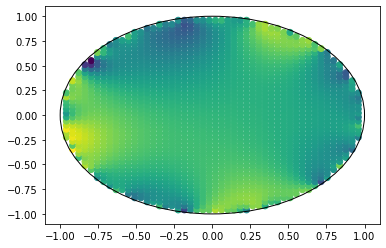

In [12]:
init_lengthscale, init_nu, init_variance = 3.0, 5.0 + space.dim, 5.0
measure = SqExpSpectralMeasure(space.dim, lengthscale=init_lengthscale, variance=init_variance)
#self.measure = MaternSpectralMeasure(self.space.dim, self.lengthscale, self.nu)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
geometric_spectral_kernel = RandomSpectralKernel(measure, space)
geometric_rff_kernel = RandomFourierFeatureKernel(geometric_spectral_kernel)
geometric_sampler = RandomFourierApproximation(geometric_spectral_kernel)

train_y, test_y = geometric_sampler(train_x), geometric_sampler(test_x)

plot_disc(test_x, test_y)

In [13]:
lengthscale, nu, variance = 1.0, 5.0 + space.dim, 1.0
measure = SqExpSpectralMeasure(space.dim, lengthscale, variance=variance)
#self.measure = MaternSpectralMeasure(self.space.dim, self.lengthscale, self.nu)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
geometric_spectral_kernel = RandomSpectralKernel(measure, space)
geometric_rff_kernel = RandomFourierFeatureKernel(geometric_spectral_kernel)
geometric_model = ExactGPModel(train_x, train_y, likelihood, geometric_rff_kernel).to(device=device)
train(geometric_model, train_x, train_y)

Iter 100/900 - Loss: 0.774   lengthscale: 1.788 variance: 1.753   noise: 0.299
Iter 200/900 - Loss: 0.381   lengthscale: 2.284 variance: 2.238   noise: 0.110
Iter 300/900 - Loss: -0.033   lengthscale: 2.585 variance: 2.672   noise: 0.039
Iter 400/900 - Loss: 0.034   lengthscale: 2.607 variance: 2.716   noise: 0.036
Iter 500/900 - Loss: -0.080   lengthscale: 2.628 variance: 2.764   noise: 0.032
Iter 600/900 - Loss: -0.130   lengthscale: 2.652 variance: 2.809   noise: 0.029
Iter 700/900 - Loss: -0.114   lengthscale: 2.654 variance: 2.814   noise: 0.029
Iter 800/900 - Loss: -0.113   lengthscale: 2.657 variance: 2.820   noise: 0.029
Iter 900/900 - Loss: -0.114   lengthscale: 2.659 variance: 2.826   noise: 0.028


In [14]:
trained_lengthscale = geometric_model.covar_module.kernel.measure.lengthscale.item()
trained_variance = geometric_model.covar_module.kernel.measure.variance.item()
print('original: lengthscale: %.3f variance: %.3f' % (init_lengthscale, init_variance))
print('trained: lengthscale: %.3f variance: %.3f' % (trained_lengthscale,trained_variance))


original: lengthscale: 3.000 variance: 5.000
trained: lengthscale: 2.659 variance: 2.826
